In [ ]:
import os
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import Pipeline
from sklearn.metrics import r2_score, median_absolute_error
import os

In [3]:
# Data ingestion and preprocessing
data_dir = os.path.join(".", "data")
cs_train_folder = os.path.join(data_dir, "cs-train")

In [5]:
from solution_guidance.cslib import *
df = fetch_data(cs_train_folder)

In [7]:
# Preprocessing step: Convert the invoice_date to datetime format
df['invoice_date'] = pd.to_datetime(df['invoice_date'])
df['month'] = df['invoice_date'].dt.month
df['year'] = df['invoice_date'].dt.year

# Step 1: Investigate the relationship between the relevant data, the target, and the business metric.
# This includes revenue distribution by country and year

In [8]:
# Pivot table: Country vs. Year with revenue sum
df1 = pd.crosstab(df['country'], df['year'], values=df['price'], aggfunc='sum', margins=True, margins_name='total')
df1 = df1.sort_values('total', ascending=False)
print(df1.head(11))

year                 2017         2018         2019        total
country                                                         
total           198307.76  2526012.744  1189876.862  3914197.366
United Kingdom  187241.07  2272135.643  1062136.792  3521513.505
EIRE              4433.09    74398.300    28237.820   107069.210
Germany           1525.79    30554.331    17191.700    49271.821
France            1200.34    24538.340    14826.460    40565.140
Norway             123.28    34716.400     3655.070    38494.750
Spain              845.22     7311.560     7884.210    16040.990
Hong Kong             NaN     8715.380     5737.190    14452.570
Portugal           294.35     4292.260     8942.060    13528.670
Singapore             NaN      372.510    12803.410    13175.920
Netherlands        384.26     8948.110     2990.430    12322.800


In [9]:
# Pivot table: Country vs. Year with revenue sum
df1 = pd.crosstab(df['country'], df['year'], values=df['price'], aggfunc='sum', margins=True, margins_name='total')
df1 = df1.sort_values('total', ascending=False)
print(df1.head(11))

year                 2017         2018         2019        total
country                                                         
total           198307.76  2526012.744  1189876.862  3914197.366
United Kingdom  187241.07  2272135.643  1062136.792  3521513.505
EIRE              4433.09    74398.300    28237.820   107069.210
Germany           1525.79    30554.331    17191.700    49271.821
France            1200.34    24538.340    14826.460    40565.140
Norway             123.28    34716.400     3655.070    38494.750
Spain              845.22     7311.560     7884.210    16040.990
Hong Kong             NaN     8715.380     5737.190    14452.570
Portugal           294.35     4292.260     8942.060    13528.670
Singapore             NaN      372.510    12803.410    13175.920
Netherlands        384.26     8948.110     2990.430    12322.800


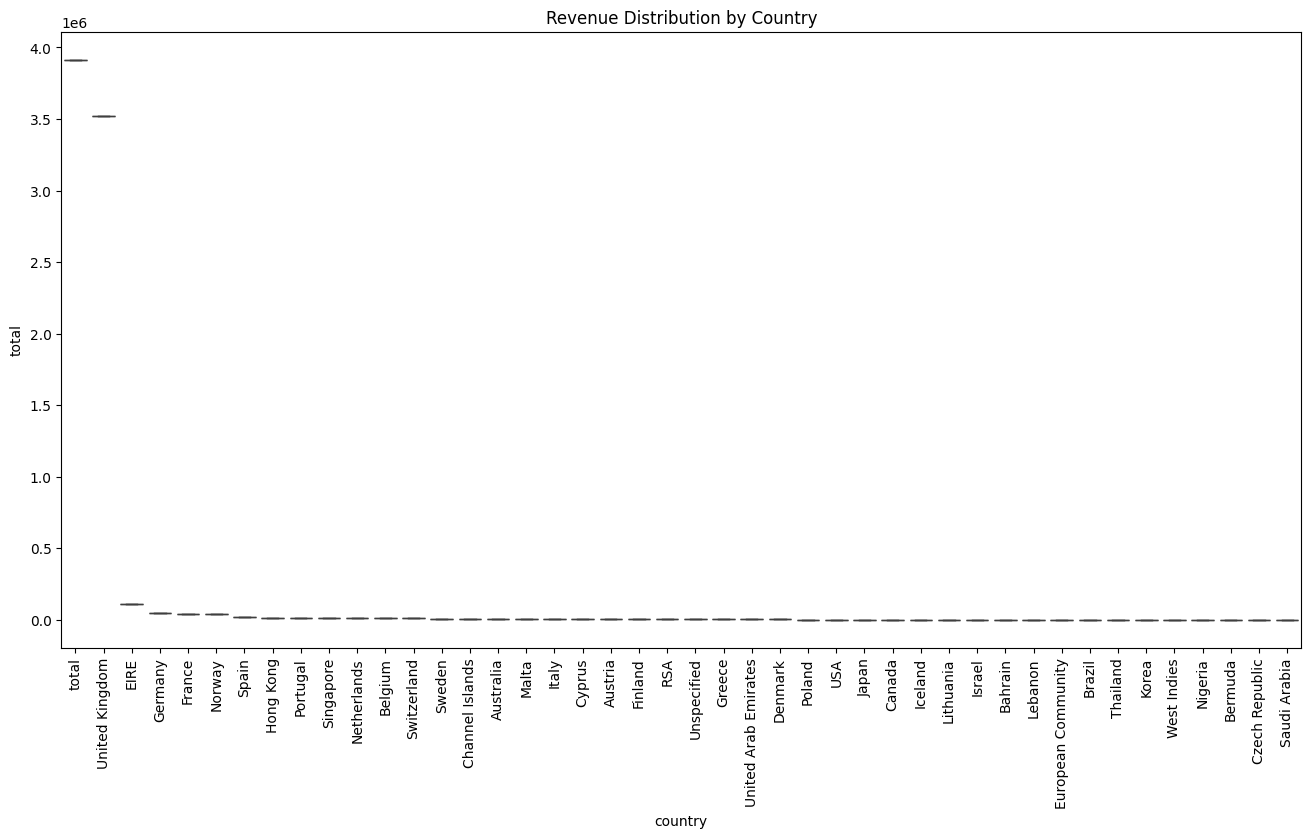

In [10]:
# Plot top 10 countries by revenue
plt.figure(figsize=(16, 8))
sns.boxplot(x='country', y='total', data=df1)
plt.xticks(rotation=90)
plt.title('Revenue Distribution by Country')
plt.show()

# Step 2: Month-wise revenue distribution by country

In [12]:
df2 = pd.crosstab(df['country'], [df['year'], df['month']], values=df['price'], aggfunc='sum', margins=True, margins_name='total')
df2 = df2.sort_values('total', ascending=False)
df2 = df2.head(11)
df2 = df2.transpose()
print(df2)

country            total  United Kingdom       EIRE    Germany    France  \
year  month                                                                
2017  11       41152.750       39445.590     570.21    156.480    352.42   
      12      157155.010      147795.480    3862.88   1369.310    847.92   
2018  1       183680.394      156741.514   14825.74   2121.430   1564.87   
      2       116345.374      103386.264    2523.79   1570.700   1694.52   
      3       257428.441      211490.981    4686.84   2427.520    911.74   
      4       116642.342      103206.131    3042.55   2352.251    705.27   
      5       155748.790      136435.360    3761.58   1469.110   1475.30   
      6       229099.440      217849.500    3044.98   2937.690   1214.97   
      7       108378.730       91460.410    4133.82   4130.510   4783.86   
      8       156605.000      135892.280    2789.03   1535.460   3351.60   
      9       222500.981      204623.941    8468.86   2286.980   1489.05   
      10    

# Step 3: Time series conversion and feature engineering for model building

In [13]:
df_new = convert_to_ts(df)
df_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 607 entries, 0 to 606
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype        
---  ------           --------------  -----        
 0   date             607 non-null    datetime64[s]
 1   purchases        607 non-null    int32        
 2   unique_invoices  607 non-null    int64        
 3   unique_streams   607 non-null    int64        
 4   total_views      607 non-null    int64        
 5   year_month       607 non-null    object       
 6   revenue          607 non-null    float64      
dtypes: datetime64[s](1), float64(1), int32(1), int64(3), object(1)
memory usage: 31.0+ KB


In [22]:
df_new['year'] = df_new['date'].dt.year
df_new['month'] = df_new['date'].dt.month

In [23]:
# Drop the original 'date' column after extracting features
df_new = df_new.drop(columns=['date'])

In [24]:
# Encode categorical columns like 'country' using one-hot encoding or label encoding
df_new = pd.get_dummies(df_new, drop_first=True)

In [25]:
X = df_new.drop(columns=['revenue'])  # Drop the target column from the features
y = df_new['revenue']  # Your target variable

# Step 4: Feature engineering

In [27]:
def engineer_features(ts):
    X = ts.drop(columns=['revenue', 'date'])  # Exclude target and date for features
    y = ts['revenue']
    return X, y



# Step 5: Train-test split for modeling

In [28]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

# Step 6: Set up and train the Random Forest model pipeline

In [29]:
pipe = Pipeline([
    ("scaler", StandardScaler()), 
    ("rf", RandomForestRegressor(n_estimators=20))
])

In [30]:
# Train the model
pipe.fit(X_train, y_train)

Pipeline(steps=[('scaler', StandardScaler()),
                ('rf', RandomForestRegressor(n_estimators=20))])

In [ ]:
# Evaluate the model
y_pred = pipe.predict(X_test)

In [32]:
# Print evaluation metrics
print(f'R^2 = {r2_score(y_test, y_pred):.2f}')
print(f'MAE = {median_absolute_error(y_test, y_pred):.2f}')

R^2 = 0.02
MAE = 1270.11
